In [2]:
import os
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from evaluate import load
from textwrap import wrap
from torch.utils.data import Dataset
from datasets import load_dataset, concatenate_datasets, load_from_disk
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers import TrainingArguments, Trainer

In [2]:
# Flickr30k датасет - состоит из 30 000 изображений, каждое из которых связано с пятью разными подписями,
# обеспечивающими точное описание основных объектов и событий. В них нет известных людей или мест.
# Демонстрирует разных сцен и ситуаций.
ds_flickr30k = load_dataset("lmms-lab/flickr30k")

ds_flickr30k

DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'img_id', 'filename'],
        num_rows: 31783
    })
})

In [3]:
# Функция поиска в подписях изображений упоминаний про детей, младенцев, мальчиков, девочек
def check_for_children(caption_list):
    keywords = ["child", "kid", "baby", "toddler", "infant"]
    return any(
        keyword in caption.lower() for keyword in keywords for caption in caption_list
    )

In [4]:
# Бинарная разметка датасета по наличию детей
ds_flickr30k["test"] = ds_flickr30k["test"].add_column(
    "has_children",
    [check_for_children(example["caption"]) for example in ds_flickr30k["test"]],
)

# Фильтрация датасета только на детей
filter_ds_flickr30k = ds_flickr30k["test"].filter(
    lambda example: example["has_children"]
)

# Удаление лишней информации
filter_ds_flickr30k = filter_ds_flickr30k.remove_columns(
    ["sentids", "has_children", "img_id", "filename"]
)

filter_ds_flickr30k

Filter:   0%|          | 0/31783 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 5467
})

In [5]:
# NoCaps датасет - состоит из 166 100 созданных человеком подписей, описывающих 15 100 изображений
# из проверочных и тестовых наборов Open Images.
ds_nocaps = load_dataset("lmms-lab/NoCaps")

ds_nocaps

DatasetDict({
    validation: Dataset({
        features: ['image', 'image_coco_url', 'image_date_captured', 'image_file_name', 'image_height', 'image_width', 'image_id', 'image_license', 'image_open_images_id', 'annotations_ids', 'annotations_captions'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['image', 'image_coco_url', 'image_date_captured', 'image_file_name', 'image_height', 'image_width', 'image_id', 'image_license', 'image_open_images_id', 'annotations_ids', 'annotations_captions'],
        num_rows: 10600
    })
})

In [6]:
# Бинарная разметка датасета по наличию детей
ds_nocaps["validation"] = ds_nocaps["validation"].add_column(
    "has_children",
    [
        check_for_children(example["annotations_captions"])
        for example in ds_nocaps["validation"]
    ],
)

# Фильтрация датасета только на детей
filter_ds_nocaps = ds_nocaps["validation"].filter(
    lambda example: example["has_children"]
)

# Удаление лишней информации
filter_ds_nocaps = filter_ds_nocaps.remove_columns(
    [
        "annotations_ids",
        "has_children",
        "image_open_images_id",
        "image_license",
        "image_width",
        "image_height",
        "image_date_captured",
        "image_coco_url",
        "image_file_name",
        "image_id",
    ]
)

# Переименование колонок под соответствие первому датасету
filter_ds_nocaps = filter_ds_nocaps.rename_columns({"annotations_captions": "caption"})

filter_ds_nocaps

Filter:   0%|          | 0/4500 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 273
})

In [7]:
# Объединение дву датасетов для дообучения моделей
ds_train = concatenate_datasets([filter_ds_flickr30k, filter_ds_nocaps])

ds_train

Dataset({
    features: ['image', 'caption'],
    num_rows: 5740
})

In [8]:
# Функция фильтрации описаний, что бы было одно
def get_first_caption(example):
    example["caption"] = example["caption"][0]
    return example


ds_train = ds_train.map(get_first_caption)

Map:   0%|          | 0/5740 [00:00<?, ? examples/s]

In [9]:
# Сохранение предобработанного датасета
ds_train.save_to_disk("datasets/ds_train")

Saving the dataset (0/2 shards):   0%|          | 0/5740 [00:00<?, ? examples/s]

In [2]:
# Загрузка предобработанного датасета
ds_train = load_from_disk("datasets/ds_train")

In [3]:
# Разделение датасета на обучающую и тестовую выборку
ds = ds_train.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

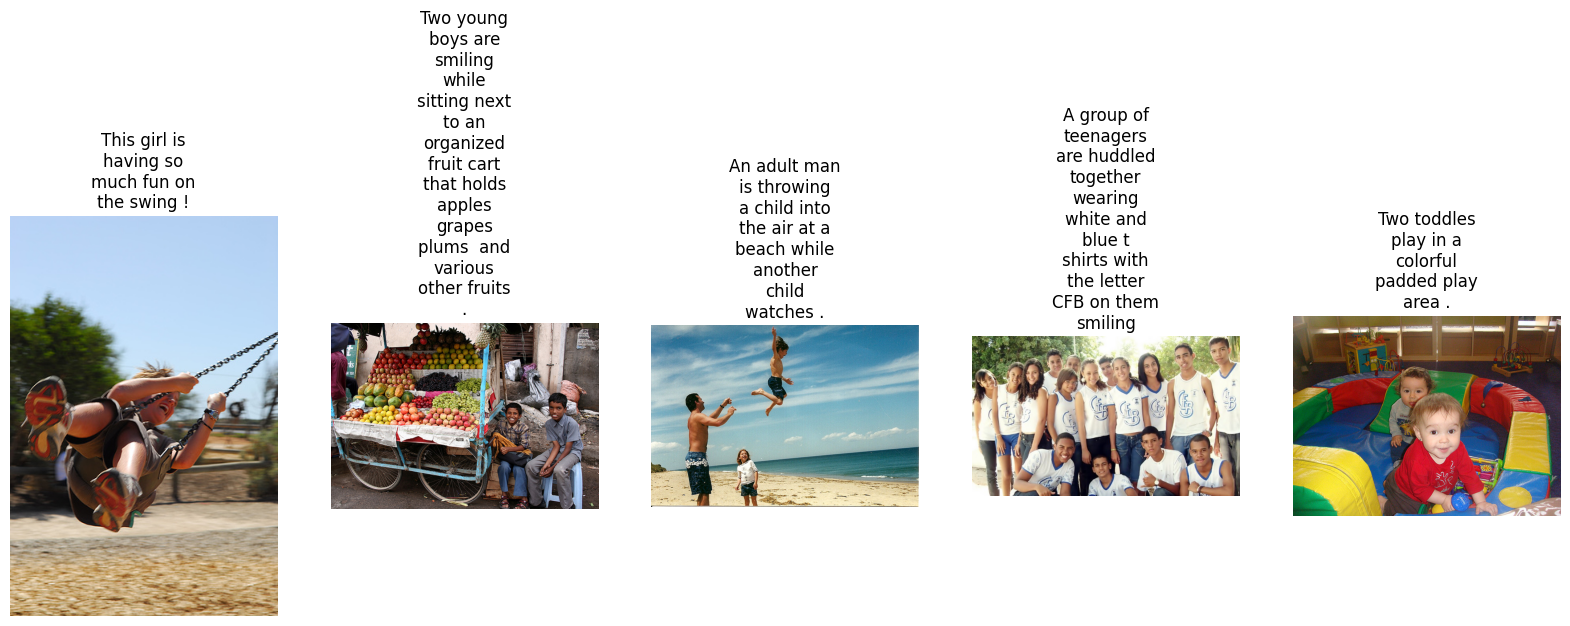

In [4]:
# Визуализация нескольких примеров из обучающей выборки
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["caption"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [7]:
# Подготовка базовой модели которую будем дообучать
processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [8]:
# Функция предварительной обработки изображения (изменение размера и масштабирование пикселей) и токенизацию подписи
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["caption"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [9]:
# Определение loss дообучения
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"WER score": wer_score}

In [11]:
# Задает аргументы дообучения модели
training_args = TrainingArguments(
    output_dir="git-base-train",
    learning_rate=5e-5,
    num_train_epochs=25,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=500,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [12]:
# Фиксируем все параметры для старта дообучения
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
model.save_pretrained("models/git-base-train")

In [2]:
# Кастомный класс создания синтетического датасета
class CustomDataset(Dataset):
    def __init__(self, data_dir, data, transform=None):
        self.data_dir = data_dir
        self.data = data
        self.transform = transform
        self.images = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image, caption = loader(image_path, self.data)
        if self.transform:
            image = self.transform(image)
        return image, caption


def loader(path, data):
    image = Image.open(path)
    caption = data.loc[data["image"] == os.path.basename(path), "caption"].values[0]
    return image, caption

In [3]:
data_dir = "datasets/sin_dataset_img"

data = pd.read_csv(f"{data_dir}/captions.csv")

ds_sin = CustomDataset(f"{data_dir}/images", data)

In [4]:
# Функция расчета метрики METEOR
def metric_meteor(predicted_captions, reference_captions):
    meteor = load("meteor")
    meteor_avg = meteor.compute(
        predictions=predicted_captions, references=reference_captions
    )

    return meteor_avg

In [5]:
# Функция расчета метрики ROUGE
def metric_rouge(predicted_captions, reference_captions):
    rouge = load("rouge")
    rouge_avg = rouge.compute(
        predictions=predicted_captions, references=reference_captions
    )

    return rouge_avg

In [6]:
# Функция расчета метрики WER
def metric_wer(predicted_captions, reference_captions):
    wer = load("wer")
    wer_avg = wer.compute(predictions=predicted_captions, references=reference_captions)

    return wer_avg

In [7]:
# Дообученная (простая) модель генерации описания изображений
model_name = "models/git-base-train"

wandb.init(project="child_diary", group=model_name, job_type="train")

# Загрузка модели генерации описаний изображений
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

predicted_captions = []
reference_captions = []

start_time = time()

# Выполнение предсказания модели
for image, captions in ds_sin:
    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    pred_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    predicted_captions.append(pred_caption)
    reference_captions.append(captions)

end_time = time()

rouge_result = metric_rouge(predicted_captions, reference_captions)

wandb.log(
    {
        "METEOR": metric_meteor(predicted_captions, reference_captions),
        "ROUGE-1": rouge_result["rouge1"],
        "ROUGE-2": rouge_result["rouge2"],
        "ROUGE-L": rouge_result["rougeL"],
        "WER": metric_wer(predicted_captions, reference_captions),
        "Speed 1 image": (end_time - start_time) / len(ds_sin),
    }
)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: n-hilkovich. Use `wandb login --relogin` to force relogin


[nltk_data] Downloading package wordnet to /home/nikolai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nikolai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nikolai/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ROUGE-1,▁
ROUGE-2,▁
ROUGE-L,▁
Speed 1 image,▁
WER,▁
ROUGE-1,0.36691
ROUGE-2,0.10801
ROUGE-L,0.30535
Speed 1 image,4.99827
WER,0.88112
